In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json


class TSGenerator:
    def __init__(self, TSconfig):
        self.number_of_observations = TSconfig["number_of_observations"]

    def base_TS(self, TSconfig):
        base = TSconfig["base"]
        var = TSconfig["variance"]

        self.time_series["data"] = self.time_series["data"].apply(lambda obs: obs + np.random.normal(base, var, 1)[0])        

    def add_trend(self, TSconfig):
        slope = TSconfig["slope"]
        self.time_series["index"] = self.time_series.index
        self.time_series["trend"] = self.time_series["index"].apply(lambda obs: slope * obs)
        self.time_series["data"] = self.time_series["data"] + self.time_series["trend"]

        self.time_series.drop("trend", inplace=True, axis=1)
        self.time_series.drop("index", inplace=True, axis=1)

    def add_season(self, TSconfig):
        period = TSconfig["period"]
        height = TSconfig["height"]

        self.time_series["index"] = self.time_series.index
        self.time_series["season"] = self.time_series["index"].apply(lambda obs: height * math.sin(obs * 2 * math.pi / period))
        self.time_series["data"] = self.time_series["data"] + self.time_series["season"]

        self.time_series.drop("season", inplace=True, axis=1)
        self.time_series.drop("index", inplace=True, axis=1)

    def add_anomalies(self, TSconfig):

        anomalies = TSconfig
        for anomaly in anomalies:
            position = anomaly["position"]
            coeficient = anomaly["coef"]
            self.time_series["data"].iloc[position] = (self.time_series["data"].iloc[position] * coeficient)

    def add_jumps(self, TSconfig):

        breaks = TSconfig
        for record in breaks:
            start = record["from"]
            end = record["to"]
            value = record["value"]
            self.time_series["data"].iloc[start : end + 1] = (self.time_series["data"] + value)

    def add_timestamp(self, TSconfig):
        start = TSconfig["start"]
        step = TSconfig["step"]

        self.time_series["index"] = self.time_series.index
        self.time_series["timestamp"] = self.time_series["index"].apply(lambda obs: start + obs * step)

        self.time_series.set_index("timestamp", inplace=True)

        self.time_series.drop("index", inplace=True, axis=1)

    def plot(self):
        self.time_series.plot()
        plt.show()

    def to_csv(self, file_name):
        self.time_series.to_csv(file_name, sep=",", index=True)
        print(("Time series " + file_name + " saved."))

    def generate(self, TSconfig):

        self.time_series = pd.DataFrame({"data": np.zeros(self.number_of_observations)})

        for key in TSconfig:
            if key == "base_line":
                self.base_TS(TSconfig=TSconfig[key])
            elif key == "trend":
                self.add_trend(TSconfig=TSconfig[key])
            elif key == "season":
                self.add_season(TSconfig=TSconfig[key])
            elif key == "annomalies":
                self.add_anomalies(TSconfig=TSconfig[key])
            elif key == "breaks":
                self.add_jumps(TSconfig=TSconfig[key])
            elif key == "meta":
                pass
            elif key == "timestamps":
                self.add_timestamp(TSconfig=TSconfig[key])
            else:
                raise ValueError("A key " + key + " is not defined!")

    def get(self):
        return self.time_series

    def get_data(self):
        _ts = self.time_series.copy()

        days = len(_ts.values.flatten())
        calendar = pd.date_range(start="20000101", freq="B", periods=days)
        time_series = pd.Series(data=_ts.values.flatten(), index=calendar)

        return time_series

In [2]:
config_ts = {
      "meta": {
        "path": "./timeseries/",
        "time_series_name": "11-base-trend-season-anomaly-regular",
        "number_of_observations": 1000
      },
      "base_line": {
        "base": 1000,
        "variance": 200
      },
      # "trend": {
      #   "slope": 20
      # },
      "season": {
        "period": 45,
        "height": 4.9
      },
      "annomalies": [
        {
          "position": 21,
          "coef": 2
        },
        {
          "position": 250,
          "coef": 2
        },
        {
          "position": 900,
          "coef": 0.01
        },
      ],
      "timestamps": {
        "start": 0,
        "step": 10
      }, 
      "breaks": [{'from': 37, 'to': 558, 'value': 7}]
        }

In [3]:
NUMBER_SERIES = 1
NUMBER_DAYS = 1000

In [4]:
# Generate time series
series = []
generator = TSGenerator(config_ts["meta"])
generator.generate(config_ts)
ts = generator.get_data()
ts.name = 1
series.append(ts)

In [5]:
time_series = pd.DataFrame(series).T
time_series.index.name = "date"

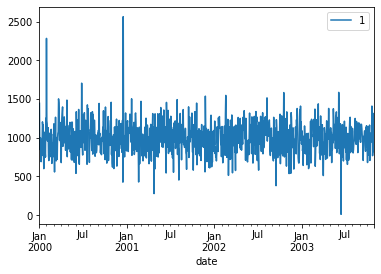

In [7]:
time_series.plot()